<div style="text-align: center; padding: 20px; background-color: #000000; border-radius: 10px; margin: 20px 0;">
    <h1 style="color: #008080 	;">Analyze the Likelihood of Scoring a Goal through a Shot<h1>
    <hr style="border: 2px solid #008080;">
</div>

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

### Loading data

In [2]:
DATA_PATH = "football.csv"

In [3]:
raw_data = pd.read_csv(DATA_PATH)

### Brief look at the data

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8925 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8925 non-null   object 
 1   playerId               8925 non-null   object 
 2   playType               8925 non-null   object 
 3   bodyPart               8925 non-null   object 
 4   x                      8925 non-null   float64
 5   y                      8925 non-null   float64
 6   interveningOpponents   8925 non-null   int64  
 7   interveningTeammates   8925 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8925 non-null   int64  
 10  second                 8925 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 836.8+ KB


In [5]:
raw_data.describe()

,x,y,interveningOpponents,interveningTeammates,minute,second
count,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000
mean,14.564631,0.364408,2.531989,0.336471,48.541401,29.243810
std,7.841865,8.999063,1.386693,0.680175,26.397998,17.306565
min,0.000000,-33.920000,0.000000,0.000000,0.000000,0.000000
25%,8.480000,-5.740000,2.000000,0.000000,26.000000,14.000000
50%,12.470000,0.500000,2.000000,0.000000,49.000000,29.000000
75%,20.950000,6.730000,3.000000,0.000000,71.000000,44.000000
max,70.820000,33.920000,11.000000,7.000000,98.000000,59.000000


In [6]:
raw_data.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal


In [7]:
print("Unique values:\n")

for column in raw_data.columns:
	if len(raw_data[column].unique()) < 15:
		print(f"\033[94m{column}\033[0m")
		print(raw_data[column].unique())
		print()

Unique values:

playType
['open play' 'free kick' 'penalty' 'olimpico']

bodyPart
['right foot' 'left foot' 'head' 'other']

interveningOpponents
[ 1  3  6  4  2  8  5  7  0  9 10 11]

interveningTeammates
[0 2 1 3 4 5 7]

interferenceOnShooter
['medium' 'low' 'high' nan]

outcome
['goal' 'saved by keeper' 'missed chance' 'blocked shot' 'hit the post'
 nan]



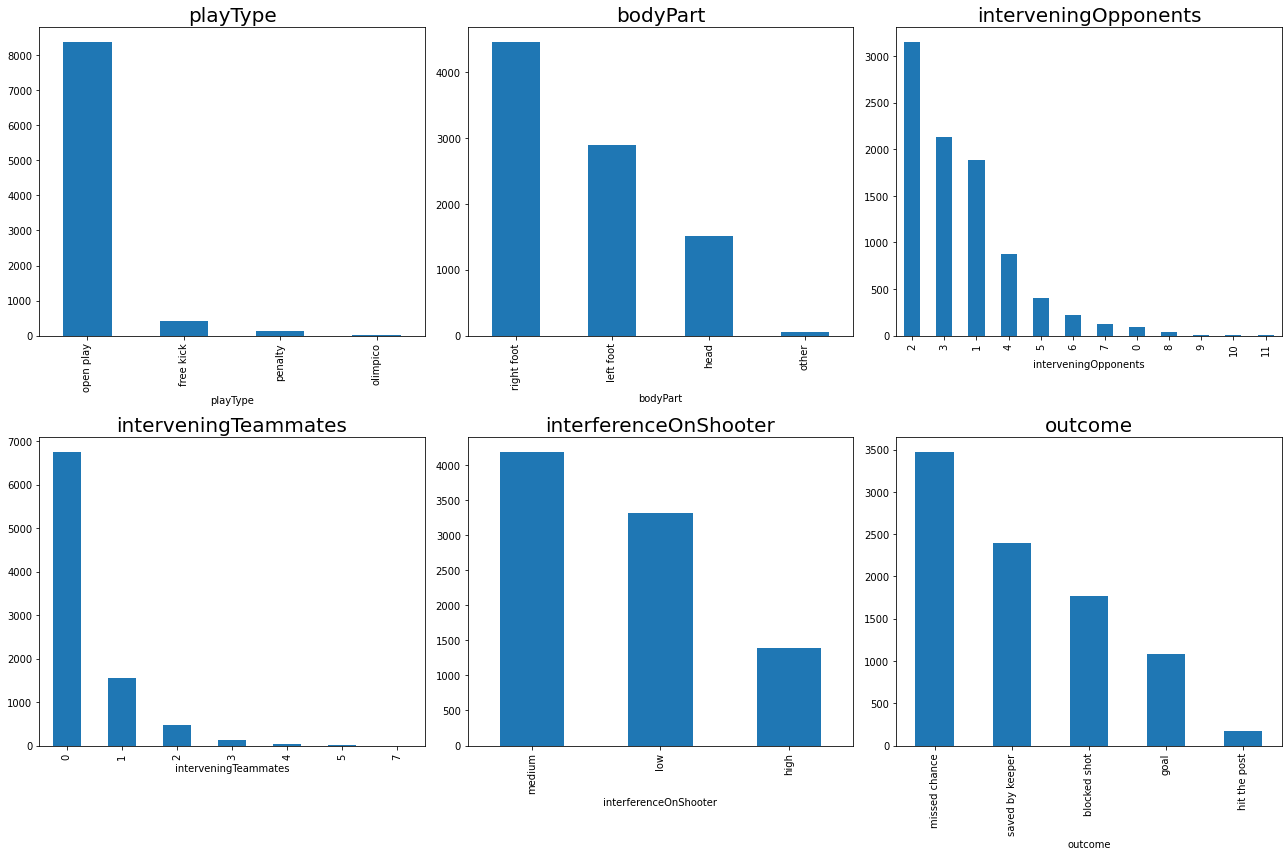

In [8]:
plt.figure(figsize=(18, 12))
subplot_index = 0

for column in raw_data.columns:
		if len(raw_data[column].unique()) < 15:
				subplot_index += 1
				plt.subplot(2, 3, subplot_index)
				raw_data[column].value_counts().plot(kind='bar')
				plt.title(column, fontsize=20)

plt.tight_layout()
plt.show()

## Preprocessing the data

In [9]:
raw_data.isnull().sum()

matchId                   0
playerId                  0
playType                  0
bodyPart                  0
x                         0
y                         0
interveningOpponents      0
interveningTeammates      0
interferenceOnShooter    34
minute                    0
second                    0
outcome                  34
dtype: int64

In [10]:
print(raw_data.duplicated().sum())

0


In [11]:
football_df = raw_data.dropna()
football_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8891 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8891 non-null   object 
 1   playerId               8891 non-null   object 
 2   playType               8891 non-null   object 
 3   bodyPart               8891 non-null   object 
 4   x                      8891 non-null   float64
 5   y                      8891 non-null   float64
 6   interveningOpponents   8891 non-null   int64  
 7   interveningTeammates   8891 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8891 non-null   int64  
 10  second                 8891 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 903.0+ KB


### Removing extra features

In [12]:
football_df = football_df.drop(columns=['matchId'])

### Label encoding for categorical data

In [13]:
playType_mapping = {'olimpico': 0, 'free kick': 1, 'open play': 2, 'penalty': 3}
bodyPart_mapping = {'other': 0, 'head': 1, 'left foot': 2, 'right foot': 3}
interferenceOnShooter_mapping = {'low': 2, 'medium': 1, 'high': 0}

football_df['playType'] = football_df['playType'].map(playType_mapping)
football_df['bodyPart'] = football_df['bodyPart'].map(bodyPart_mapping)
football_df['interferenceOnShooter'] = football_df['interferenceOnShooter'].map(interferenceOnShooter_mapping)
football_df['outcome'] = football_df['outcome'].apply(lambda x: 1 if x == 'goal' else 0)

football_df

,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,p_103,2,3,13.47,-11.22,1,0,1,70,9,1
1,p_16,2,2,9.48,14.22,3,0,1,55,4,0
2,p_88,1,2,29.43,-1.25,6,2,2,86,31,0
3,p_87,2,3,26.93,1.00,4,1,1,77,2,0
4,p_9,2,3,10.72,5.24,2,0,1,76,46,1
...,...,...,...,...,...,...,...,...,...,...,...
8920,p_115,2,1,6.48,3.99,3,0,0,69,50,0
8921,p_76,2,3,21.45,-8.73,4,1,1,15,53,0
8922,p_150,2,2,11.97,3.24,3,0,1,84,34,0
8923,p_130,2,3,6.48,-6.98,1,0,0,4,39,0


### Raw data correlation

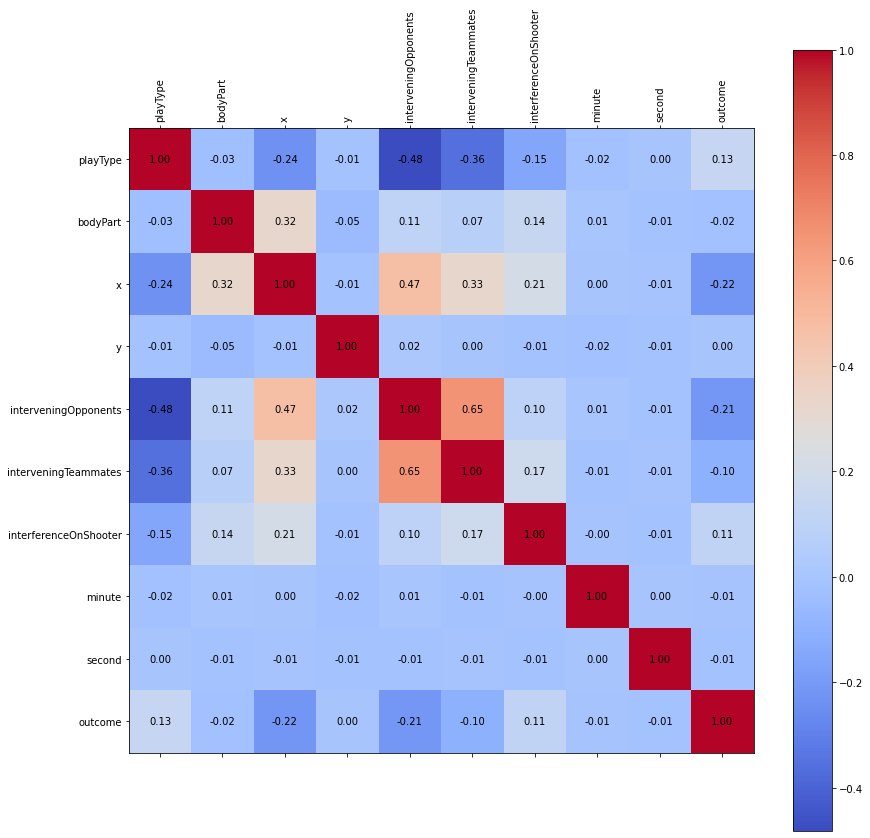

In [14]:
corr = football_df.drop(columns=['playerId']).corr()

plt.figure(figsize=(14, 14))
plt.matshow(corr, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
for (i, j), val in np.ndenumerate(corr):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.show()

In [15]:
print("Correlation with target:")
correlation = football_df.drop(columns=['playerId']).corr()
correlation['outcome'].sort_values(ascending=False)[1:]

Correlation with target:


playType                 0.133457
interferenceOnShooter    0.109000
y                        0.001947
minute                  -0.006726
second                  -0.012555
bodyPart                -0.015263
interveningTeammates    -0.101162
interveningOpponents    -0.213680
x                       -0.216209
Name: outcome, dtype: float64

## Training models

### Splitting train and test data

In [16]:
X = football_df.drop(columns=['outcome', 'playerId', 'y', 'minute', 'second'])
y = football_df['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Classifier (Raw Data)

In [17]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

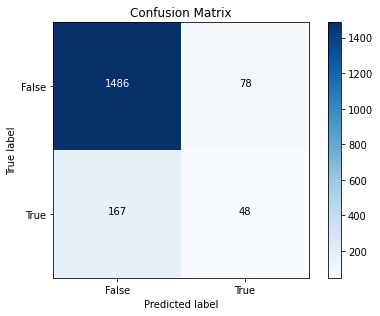

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4.5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(conf_matrix.shape[1]), ['False', 'True'])
plt.yticks(np.arange(conf_matrix.shape[0]), ['False', 'True'])
plt.tight_layout()
plt.show()

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy: 0.8622821810005621

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1564
           1       0.38      0.22      0.28       215

    accuracy                           0.86      1779
   macro avg       0.64      0.59      0.60      1779
weighted avg       0.84      0.86      0.85      1779



### Logistic Regression (Raw Data)

In [20]:
logreg = LogisticRegression(max_iter=250)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

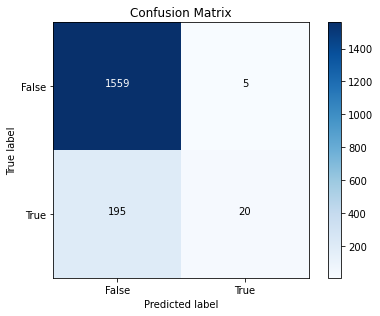

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4.5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(conf_matrix.shape[1]), ['False', 'True'])
plt.yticks(np.arange(conf_matrix.shape[0]), ['False', 'True'])
plt.tight_layout()
plt.show()

In [22]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8875772906127037

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1564
           1       0.80      0.09      0.17       215

    accuracy                           0.89      1779
   macro avg       0.84      0.54      0.55      1779
weighted avg       0.88      0.89      0.85      1779



## Feature Engineering

#### Calculating `distance` and `angle`

In [23]:
# calculating distance (using radical x^2 + y^2)
football_df['distance'] = np.sqrt(football_df['x']**2 + football_df['y']**2)

# calculating angle (using rad2deg(atan(theta))) where theta = 7.32x / (x^2 + y^2 - (7.32/2)^2)
football_df['shot_angle'] = np.rad2deg(np.arctan(7.32 * football_df['x'] / (football_df['x']**2 + football_df['y']**2 - (7.32/2)**2)))

#### Merging `minute` and `second`

In [24]:
football_df['time'] = football_df['minute'] + (football_df['second'] / 60)
football_df = football_df.drop(columns=['minute','second'])

#### Merging `interveningOpponents` and `interveningTeammates`

In [25]:
football_df['interveningPlayers'] = football_df['interveningOpponents'] + football_df['interveningTeammates']
football_df = football_df.drop(columns=['interveningOpponents','interveningTeammates'])

#### Dropping `playerId`, `x`, and `y`

In [26]:
football_df = football_df.drop(columns=['playerId'])
# football_df = football_df.drop(columns=['x','y'])

#### Calculating `expectedGoal`

In [27]:
football_df['expectedGoal'] = (50 / football_df['distance']) + (football_df['shot_angle'] / 20)

#### Calculating `isBigChance`

In [28]:
football_df['isBigChance'] = ((football_df['distance'] < 20) & (football_df['shot_angle'] > 55)).astype(int)

### Data correlation

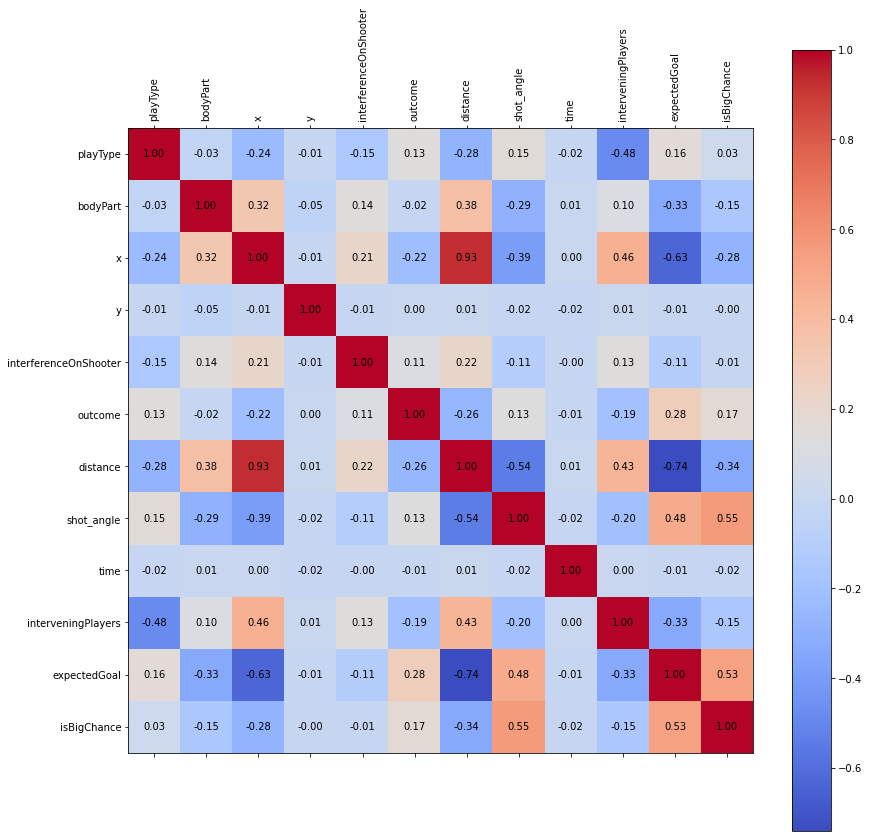

In [29]:
corr = football_df.corr()

plt.figure(figsize=(14, 14))
plt.matshow(corr, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
for (i, j), val in np.ndenumerate(corr):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.show()

### Splitting train and test data

In [30]:
X = football_df.drop(columns=['outcome', 'time'])
y = football_df['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Classifier

In [31]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

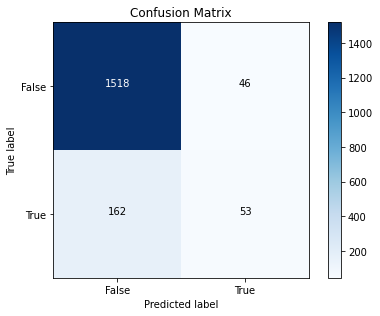

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4.5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(conf_matrix.shape[1]), ['False', 'True'])
plt.yticks(np.arange(conf_matrix.shape[0]), ['False', 'True'])
plt.tight_layout()
plt.show()

In [33]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy: 0.883080382237212

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1564
           1       0.54      0.25      0.34       215

    accuracy                           0.88      1779
   macro avg       0.72      0.61      0.64      1779
weighted avg       0.86      0.88      0.86      1779



### Logistic Regression (Raw Data)

In [34]:
logreg = LogisticRegression(max_iter=250)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

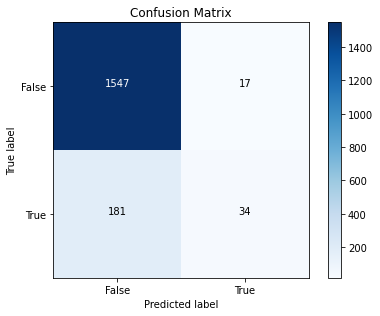

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4.5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(conf_matrix.shape[1]), ['False', 'True'])
plt.yticks(np.arange(conf_matrix.shape[0]), ['False', 'True'])
plt.tight_layout()
plt.show()

In [36]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8887015177065767

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1564
           1       0.67      0.16      0.26       215

    accuracy                           0.89      1779
   macro avg       0.78      0.57      0.60      1779
weighted avg       0.87      0.89      0.86      1779



#### Important Features

In [37]:
correlation = football_df.corr()
correlation['outcome'] = abs(correlation['outcome'])
correlation['outcome'].sort_values(ascending=False)[1:]

expectedGoal             0.282237
distance                 0.260733
x                        0.216209
interveningPlayers       0.192058
isBigChance              0.174591
playType                 0.133457
shot_angle               0.128599
interferenceOnShooter    0.109000
bodyPart                 0.015263
time                     0.006863
y                        0.001947
Name: outcome, dtype: float64

## Questions

---

##### Q1 - Describe your strategy for addressing challenges such as handling missing values and categorical features. Could you also elaborate on your feature selection metrics and explain the rationale behind them?

**Missing Values**:

We removed rows with missing values because their quantity was insignificant compared to the total amount of data available.

**categorical features**:

We treated some of the categorical features as ordinal data, such as `playType` and `interferenceOnShooter`, and assigned them values ranging from zero to n. This ranking is a theoretical order reflecting the probability of a shot resulting in a goal.

**feature selection**:

For feature selection, we considered two factors:

1- The logical impact of the feature on the shot's outcome, as informed by our knowledge of football.

2- The degree of correlation between the feature and the target variable.


---

##### Q2 - Why didn’t we use regression to predict whether a shot would result in a goal?

Regression models are typically used for predicting continuous outcomes, not binary ones. In the context of predicting whether a shot results in a goal (which is a binary outcome), a classification model is more appropriate.

Using a regression model like linear regression for a binary outcome could lead to nonsensical predictions, such as negative probabilities or probabilities greater than 1, which don't make sense in a probability framework. Logistic regression, on the other hand, ensures that the output probabilities are bounded between 0 and 1, making it a better fit for binary outcomes.

---

##### Q3 - How would you go about verifying the accuracy of the given formula used to calculate the shot angle in the preprocessing section?

We verified the accuracy of the given formula by testing the **Edge Cases**:

1- Shots at extreme angle (x = 0): such as `olimpico` shots

2- Shots directly in front of the goal (y = 0)